# 180 - LSTM Autoencoder for anomaly detection

DigitalSreeni

https://www.youtube.com/watch?v=6S2v7G-OupA

https://finance.yahoo.com/quote/GE/history/

https://stackoverflow.com/questions/72441758/typeerror-descriptors-cannot-not-be-created-directly

https://stackoverflow.com/questions/58479556/notimplementederror-cannot-convert-a-symbolic-tensor-2nd-target0-to-a-numpy

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

In [3]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [4]:
df = pd.read_csv('data/GE.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1970-01-02,4.847725,4.855544,4.785174,4.792993,0.985620,370896
1,1970-01-05,4.792993,4.816449,4.730441,4.769536,0.980797,677844
2,1970-01-06,4.761717,4.761717,4.605339,4.628796,0.951856,567534
3,1970-01-07,4.644433,4.714804,4.644433,4.652252,0.956679,736995
4,1970-01-08,4.667890,4.738260,4.667890,4.691347,0.964719,2225374
...,...,...,...,...,...,...,...
12817,2020-10-22,45.776737,48.399689,45.714287,48.212334,47.666798,15334675
12818,2020-10-23,49.523811,50.148323,47.213116,47.650272,47.111092,21226682
12819,2020-10-26,46.588604,47.213116,45.464481,46.088993,45.567482,16693736
12820,2020-10-27,46.213894,46.213894,44.277908,44.340359,43.838631,15719471


In [5]:
df = df[['Date', 'Close']]
df

,Date,Close
0,1970-01-02,4.792993
1,1970-01-05,4.769536
2,1970-01-06,4.628796
3,1970-01-07,4.652252
4,1970-01-08,4.691347
...,...,...
12817,2020-10-22,48.212334
12818,2020-10-23,47.650272
12819,2020-10-26,46.088993
12820,2020-10-27,44.340359


In [6]:
pd.to_datetime(df['Date'])

0       1970-01-02
1       1970-01-05
2       1970-01-06
3       1970-01-07
4       1970-01-08
           ...    
12817   2020-10-22
12818   2020-10-23
12819   2020-10-26
12820   2020-10-27
12821   2020-10-28
Name: Date, Length: 12822, dtype: datetime64[ns]

In [7]:
df.loc[:, 'Date'] = pd.to_datetime(df['Date'])
df

c:\k26rahul\Code\Sanika\Barclays\Finance-Yahoo-LSTM\.venv\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,Date,Close
0,1970-01-02,4.792993
1,1970-01-05,4.769536
2,1970-01-06,4.628796
3,1970-01-07,4.652252
4,1970-01-08,4.691347
...,...,...
12817,2020-10-22,48.212334
12818,2020-10-23,47.650272
12819,2020-10-26,46.088993
12820,2020-10-27,44.340359


<AxesSubplot:xlabel='Date', ylabel='Close'>

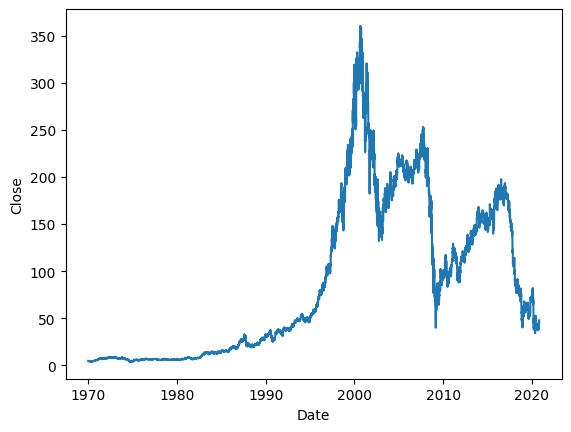

In [8]:
sns.lineplot(x=df['Date'], y=df['Close'])

In [9]:
print("Start date is: ", df['Date'].min())
print("End date is: ", df['Date'].max())

Start date is:  1970-01-02 00:00:00
End date is:  2020-10-28 00:00:00


In [10]:
train, test = df.loc[df['Date'] <= '2003-12-31'], df.loc[df['Date'] > '2003-12-31']

In [11]:
scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

c:\k26rahul\Code\Sanika\Barclays\Finance-Yahoo-LSTM\.venv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\k26rahul\Code\Sanika\Barclays\Finance-Yahoo-LSTM\.venv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [15]:
# Number of time steps to look back
# Larger sequences (look further back) may improve forecasting.
seq_size = 30

In [17]:
def to_sequences(x, y, seq_size=1):
  x_values = []
  y_values = []

  for i in range(len(x)-seq_size):
    x_values.append(x.iloc[i:(i+seq_size)].values)
    y_values.append(y.iloc[i+seq_size])

  return np.array(x_values), np.array(y_values)

In [18]:
trainX, trainY = to_sequences(train[['Close']], train['Close'], seq_size)
testX, testY = to_sequences(test[['Close']], test['Close'], seq_size)

In [19]:
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

In [20]:
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/10
241/241 [==============================] - 7s 31ms/step - loss: 0.0654 - val_loss: 0.0798
Epoch 2/10
241/241 [==============================] - 6s 25ms/step - loss: 0.0397 - val_loss: 0.0744
Epoch 3/10
241/241 [==============================] - 6s 25ms/step - loss: 0.0355 - val_loss: 0.0639
Epoch 4/10
241/241 [==============================] - 6s 25ms/step - loss: 0.0326 - val_loss: 0.1075
Epoch 5/10
241/241 [==============================] - 6s 26ms/step - loss: 0.0315 - val_loss: 0.0741
Epoch 6/10
241/241 [==============================] - 7s 29ms/step - loss: 0.0306 - val_loss: 0.0649
Epoch 7/10
241/241 [==============================] - 7s 30ms/step - loss: 0.0301 - val_loss: 0.0599
Epoch 8/10
241/241 [==============================] - 7s 30ms/step - loss: 0.0291 - val_loss: 0.0608
Epoch 9/10
241/241 [==============================] - 7s 30ms/step - loss: 0.0282 - val_loss: 0.0760
Epoch 10/10
241/241 [==============================] - 7s 31ms/step - loss: 0.0281 - val_lo

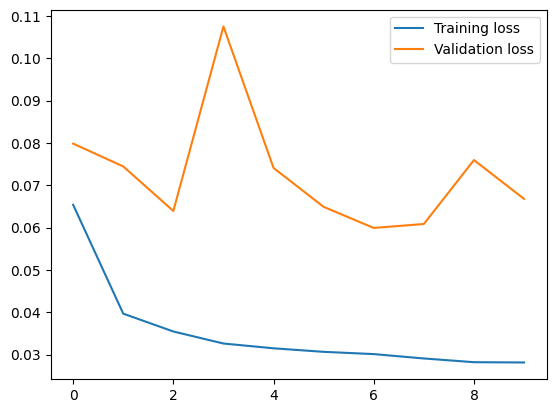

In [21]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

(array([6.286e+03, 6.020e+02, 2.890e+02, 2.440e+02, 1.930e+02, 2.240e+02,
        1.750e+02, 1.360e+02, 9.400e+01, 6.200e+01, 5.200e+01, 4.500e+01,
        2.800e+01, 3.900e+01, 2.200e+01, 1.600e+01, 1.100e+01, 1.300e+01,
        7.000e+00, 9.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([0.00097535, 0.02257531, 0.04417527, 0.06577524, 0.0873752 ,
        0.10897516, 0.13057513, 0.15217509, 0.17377505, 0.19537502,
        0.21697498, 0.23857494, 0.26017491, 0.28177487, 0.30337484,
        0.3249748 , 0.34657476, 0.36817473, 0.38977469, 0.41137465,
        0.43297462, 0.45457458, 0.47617454, 0.49777451, 0.51937447,
        0.54097443, 0.5625744 , 0.58417436, 0.60577432, 0.62737429,
        0.64897425]),
 <BarContainer object of 30 artists>)

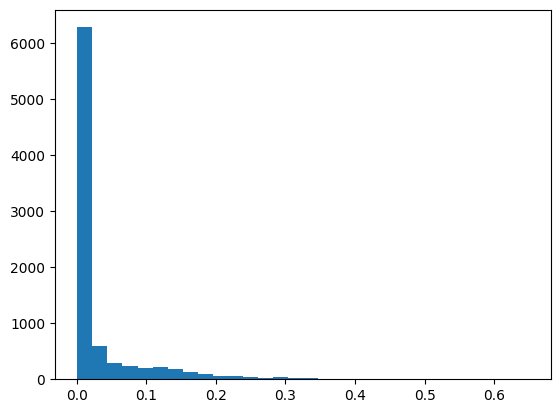

In [22]:
# Anomaly is where reconstruction error is large.
# We can define this value beyond which we call anomaly.
# Let us look at MAE in training prediction
trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=30)
max_trainMAE = 0.3  # or Define 90% value of max as threshold.

(array([455., 871., 786., 538., 402., 280., 228., 193., 107.,  67.,  59.,
         39.,  45.,  30.,  19.,  23.,  22.,   7.,   5.,   4.,   8.,   8.,
          3.,   2.,   2.,   0.,   2.,   0.,   0.,   1.]),
 array([0.0116105 , 0.0255069 , 0.0394033 , 0.0532997 , 0.0671961 ,
        0.08109251, 0.09498891, 0.10888531, 0.12278171, 0.13667811,
        0.15057452, 0.16447092, 0.17836732, 0.19226372, 0.20616013,
        0.22005653, 0.23395293, 0.24784933, 0.26174573, 0.27564214,
        0.28953854, 0.30343494, 0.31733134, 0.33122775, 0.34512415,
        0.35902055, 0.37291695, 0.38681335, 0.40070976, 0.41460616,
        0.42850256]),
 <BarContainer object of 30 artists>)

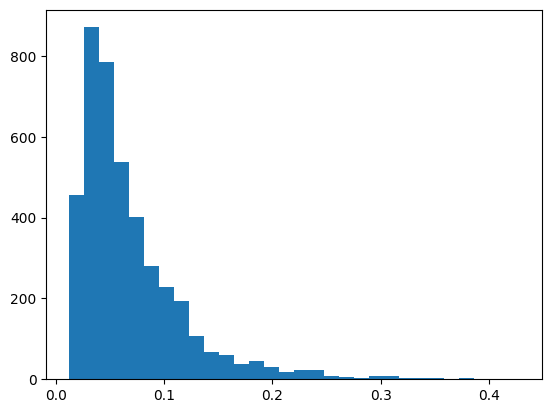

In [23]:
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30)

<AxesSubplot:xlabel='Date', ylabel='testMAE'>

<AxesSubplot:xlabel='Date', ylabel='testMAE'>

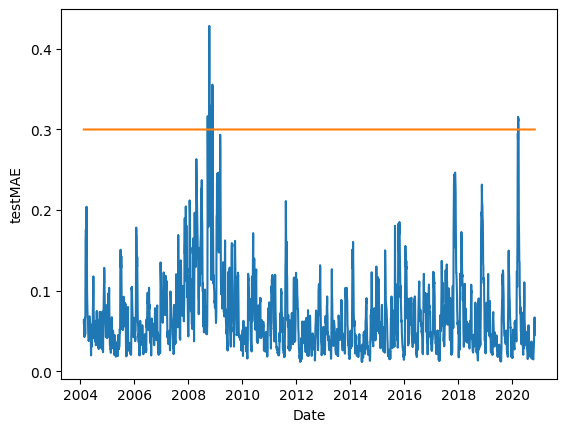

In [24]:
# Capture all details in a DataFrame for easy plotting
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['Close'] = test[seq_size:]['Close']

# Plot testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['max_trainMAE'])

In [25]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

In [26]:
anomaly_df['Date']

anomaly_df['Close']

anomaly_df['Close'].values.reshape(-1, 1)

8616    2004-02-17
8617    2004-02-18
8618    2004-02-19
8619    2004-02-20
8620    2004-02-23
           ...    
12817   2020-10-22
12818   2020-10-23
12819   2020-10-26
12820   2020-10-27
12821   2020-10-28
Name: Date, Length: 4206, dtype: datetime64[ns]

8616     1.686859
8617     1.665017
8618     1.654096
8619     1.661377
8620     1.713798
           ...   
12817   -0.134870
12818   -0.141685
12819   -0.160614
12820   -0.181816
12821   -0.157586
Name: Close, Length: 4206, dtype: float64

array([[ 1.68685949],
       [ 1.66501719],
       [ 1.65409623],
       ...,
       [-0.16061442],
       [-0.18181595],
       [-0.15758562]])

In [27]:
scaler.inverse_transform(anomaly_df['Close'].values.reshape(-1, 1))

scaler.inverse_transform(anomaly_df['Close'].values.reshape(-1, 1)).flatten()

array([[198.462738],
       [196.661255],
       [195.760529],
       ...,
       [ 46.088993],
       [ 44.340359],
       [ 46.338799]])

array([198.462738, 196.661255, 195.760529, ...,  46.088993,  44.340359,
        46.338799])

<AxesSubplot:xlabel='Date'>

<AxesSubplot:xlabel='Date'>

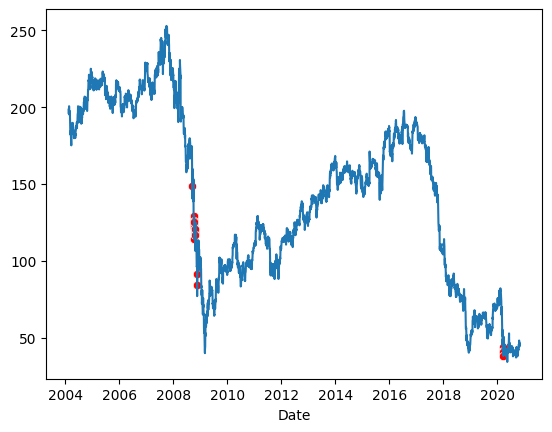

In [28]:
# Plot anomalies
sns.lineplot(x=anomaly_df['Date'], y=scaler.inverse_transform(anomaly_df['Close'].values.reshape(-1, 1)).flatten())
sns.scatterplot(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close'].values.reshape(-1, 1)).flatten(), color='r')